# 4. Evaluation Metrics for Classification
In the previous session we trained a model for predicting churn. How do we know if it's good?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/juliastache/Desktop/Courses/ml-zoomcamp/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

# 4.2 Accuracy and dummy model
- Evaluate the model on different decision thresholds
- Check the accuracy of dummy baselines

In [8]:
# Accuracy with churn_decision = 0.5
print("Accuracy with churn_decision = 0.5: {:.2f}".format((y_val == churn_decision).mean()))

Accuracy with churn_decision = 0.5: 0.80


In [9]:
# try different thresholds
thresholds = np.linspace(0, 1, 21)

scores =[]

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print("Accuracy with churn_decision = {:.2f}: {:.3f}".format(t, score))
    scores.append(score)

Accuracy with churn_decision = 0.00: 0.274
Accuracy with churn_decision = 0.05: 0.509
Accuracy with churn_decision = 0.10: 0.591
Accuracy with churn_decision = 0.15: 0.666
Accuracy with churn_decision = 0.20: 0.710
Accuracy with churn_decision = 0.25: 0.739
Accuracy with churn_decision = 0.30: 0.760
Accuracy with churn_decision = 0.35: 0.772
Accuracy with churn_decision = 0.40: 0.785
Accuracy with churn_decision = 0.45: 0.793
Accuracy with churn_decision = 0.50: 0.803
Accuracy with churn_decision = 0.55: 0.801
Accuracy with churn_decision = 0.60: 0.795
Accuracy with churn_decision = 0.65: 0.786
Accuracy with churn_decision = 0.70: 0.766
Accuracy with churn_decision = 0.75: 0.744
Accuracy with churn_decision = 0.80: 0.735
Accuracy with churn_decision = 0.85: 0.726
Accuracy with churn_decision = 0.90: 0.726
Accuracy with churn_decision = 0.95: 0.726
Accuracy with churn_decision = 1.00: 0.726


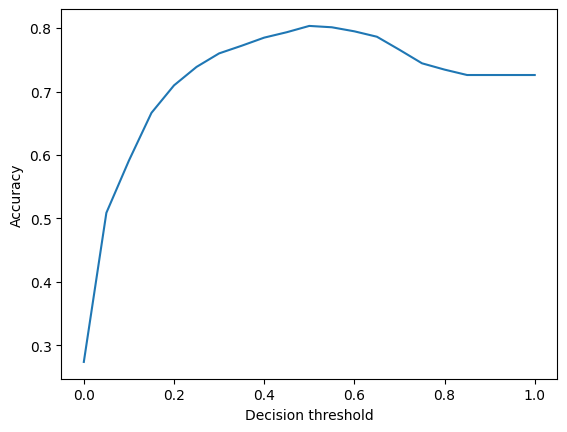

In [10]:
plt.plot(thresholds,scores)
plt.xlabel("Decision threshold")
plt.ylabel("Accuracy")
plt.show()

In [11]:
# use accuracy function by sklearn
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y_val, (y_pred>=0.5))

0.8034066713981547

In [13]:
from collections import Counter

In [14]:
# if decision threshold were 1, none of the customers would be predicted to churn
# This model already has an accuracy of almost 73%
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Accuracy is not the best metric to evaluate the model because there is a high bias towards the negative (non-churning) class - the model will be mostly correct if it predicts that a customer will not be churning. 

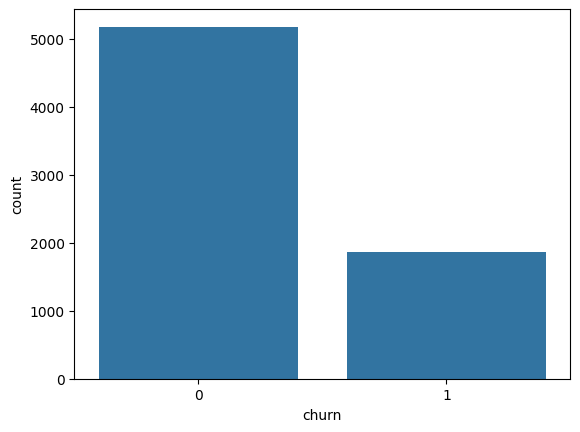

In [15]:
# plot churning vs non-churning customers
import seaborn as sns
sns.countplot(x='churn', data=df)
plt.show()

# 4.3 Confusion Table
- different types of errors and correct decisions


In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
# threshold
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
# true positive
tp = (predict_positive & actual_positive).sum()
# true negative
tn = (predict_negative & actual_negative).sum()

In [19]:
# false positives
fp = (predict_positive & actual_negative).sum()
# false negatives
fn = (predict_negative & actual_positive).sum()


In [20]:
fp

np.int64(101)

In [21]:
confusion_matrix = np.array([
    [tp, fp], 
    [fn, tn]
])
confusion_matrix


array([[210, 101],
       [176, 922]])

In [22]:
# relative values
confusion_matrix/confusion_matrix.sum()

array([[0.14904187, 0.07168204],
       [0.12491128, 0.6543648 ]])

# 4.4 Precision and Recall
Metrics for binary classification models
Precision: how many users predicted as churners are actually churners? 
Recall: how many of all churned customers are correctly predicted as churners?

In [23]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)

In [24]:
print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.6752411575562701
Recall:  0.5440414507772021


# 4.5. ROC Curves
ROC stands for Receiver Operating Characteristic. It is a graph that shows the true positive rate (TPR) and false positive rate (FPR) for each class.

In [25]:
# true positive rate: TPR = TP/(TP+FN) - same as recall
tpr = tp/(tp+fn)
# false positive rate: FPR = FP/(TN+FP)
fpr = fp/(tn+fp)

In [26]:
# calculate for all thresholds between 0 and 1 in 0.01 steps
thresholds = np.linspace(0, 1, 101)

In [27]:
def tpr_fpr_dataframe(y_val,y_pred):
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # true positive
        tp = (predict_positive & actual_positive).sum()
        # true negative
        tn = (predict_negative & actual_negative).sum()

        # false positives
        fp = (predict_positive & actual_negative).sum()
        # false negatives
        fn = (predict_negative & actual_positive).sum()

        # true positive rate: TPR = TP/(TP+FN) - same as recall
        tpr = tp/(tp+fn)
        # false positive rate: FPR = FP/(TN+FP)
        fpr = fp/(tn+fp)
        scores.append({'threshold':t, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn, 'tpr': tpr, 'fpr': fpr})

    df_scores = pd.DataFrame(scores)

    return df_scores

In [28]:
df_scores = tpr_fpr_dataframe(y_val,y_pred)
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,150,970,53,236,0.388601,0.051808
70,0.7,76,1003,20,310,0.196891,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


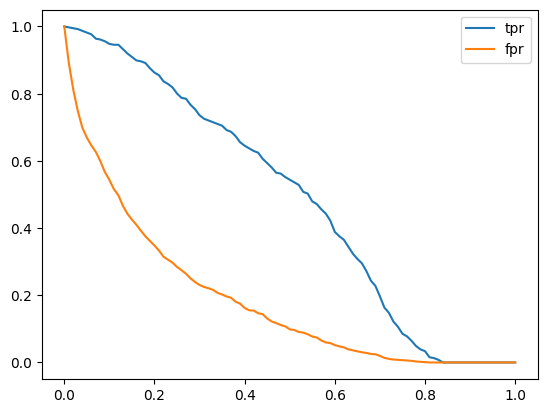

In [29]:
#plot scores
plt.plot(df_scores.threshold, df_scores.tpr, label='tpr')
plt.plot(df_scores.threshold, df_scores.fpr, label='fpr')
plt.legend()
plt.show()


The Goal is to minimize FPR and maximize TPR.

### Random Model
assign a random churn value to each customer to compare baseline model

In [30]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02], shape=(1409,))

In [31]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [32]:
df_rand_scores = tpr_fpr_dataframe(y_val,y_rand)
df_rand_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


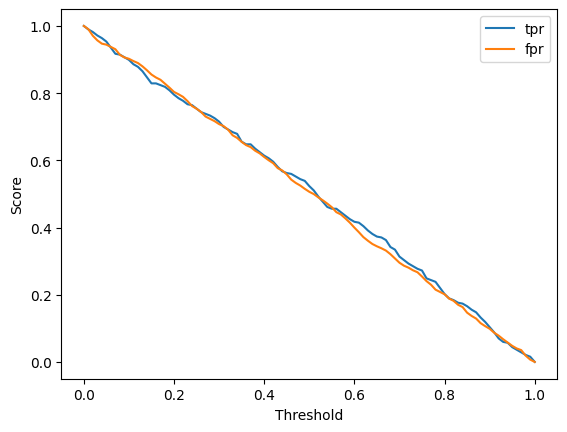

In [33]:
#plot scores
plt.plot(df_rand_scores.threshold, df_rand_scores.tpr, label='tpr')
plt.plot(df_rand_scores.threshold, df_rand_scores.fpr, label='fpr')
plt.legend()
# add a label to the x-axis
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

#### Interpretation
Threshold = 0.5 means the model will classify a person as churned if the probability of the customer being churned is greater than 50%. This means the model will correctly recall 50% of churned customers as churned, but also misclassify 50% of not churned customers as churned.

### Ideal Model
model that correctly classifies every customer. The ideal model orders the customers from lowest to highest probability and sets a correct threshold between non-churning and churning customers.
This kind of model usually doesn't exist but helps to benchmark.

In [34]:
# count positive and negative examples
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(np.int64(1023), np.int64(386))

In [35]:
# create an array that first containts 1023 zeros and then 386 ones.
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [36]:
y_ideal_pred = np.linspace(0,1,len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00], shape=(1409,))

In [37]:
# this is the correct threshold for the ideal model
1-y_val.mean()

np.float64(0.7260468417317246)

In [38]:
((y_ideal_pred>=0.726)==y_ideal).mean()

np.float64(1.0)

In [39]:
df_ideal = tpr_fpr_dataframe(y_ideal,y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


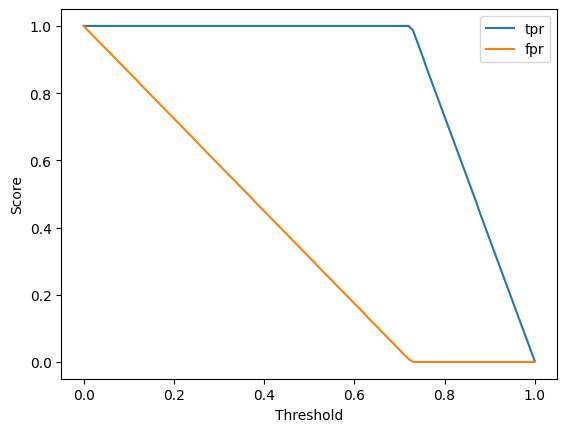

In [40]:
#plot scores
plt.plot(df_ideal.threshold, df_ideal.tpr, label='tpr')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='fpr')
plt.legend()
# add a label to the x-axis
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

In [41]:
# Recall in this model is very good up until threshold 72, but the false positive rate is still 
# not perfect until threshold 72.

### Putting all benchmarks together

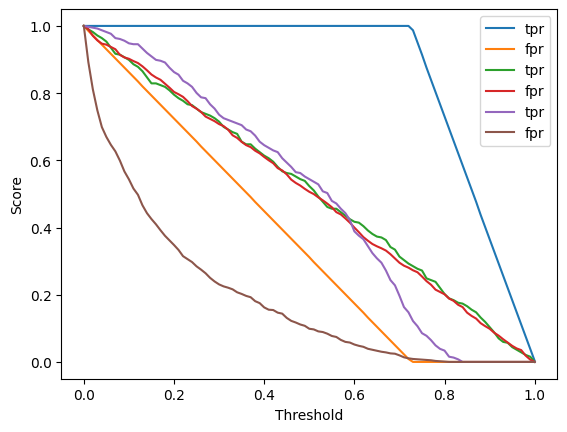

In [42]:
#plot scores
plt.plot(df_ideal.threshold, df_ideal.tpr, label='tpr')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='fpr')

plt.plot(df_rand_scores.threshold, df_rand_scores.tpr, label='tpr')
plt.plot(df_rand_scores.threshold, df_rand_scores.fpr, label='fpr')

plt.plot(df_scores.threshold, df_scores.tpr, label='tpr')
plt.plot(df_scores.threshold, df_scores.fpr, label='fpr')
plt.legend()
# add a label to the x-axis
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

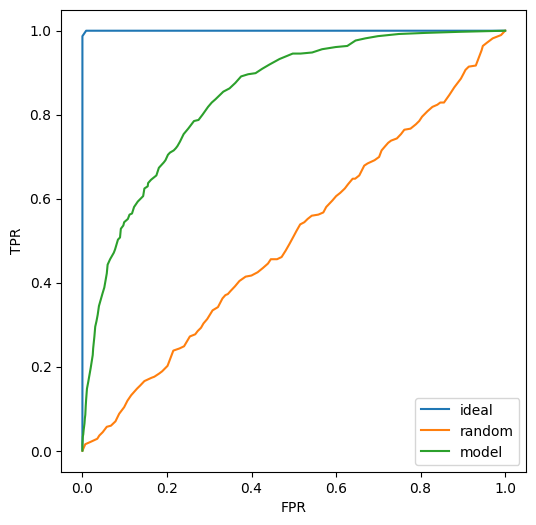

In [43]:
# Plot FPR vs TPR
plt.figure(figsize=(6,6))
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.plot(df_rand_scores.fpr, df_rand_scores.tpr, label='random')
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


 Our ideal is FPR = 0 and TPR = 1. 
The lower the threshold, the higher the TPR but also the FPR. 

# 4.5 Plotting ROC-Curves with scikit-learn

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

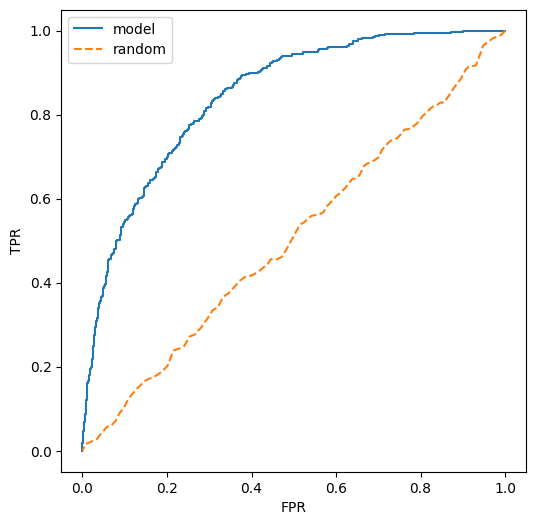

In [46]:
# Plot FPR vs TPR
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr ,label='model')
plt.plot(df_rand_scores.fpr, df_rand_scores.tpr, label='random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


# 4.6 ROC AUC
Area under (RO) curve - we want this to be as close to 1 as possible. Measure of the quality of the model.

In [47]:
from sklearn.metrics import auc # this is for any curve, not just ROC

In [48]:
# this one is more accurate because it considers more thresholds
auc(fpr, tpr)

0.8438150517374986

In [49]:
# our manual fpr and tpr
auc(df_scores.fpr, df_scores.tpr)

0.8438872259280081

In [50]:
# our manual fpr and tpr
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [51]:
# shortcut
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438150517374986

In [52]:
# AUC is the probability that a randomly selected positive example 
# has a higher score than a randomly selected negative example.

In [53]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [54]:
import random


In [55]:
n = 1000000
success = 0

for i in range(n):
    # select random positive and negative examples and compare their scores
    pos_ind  = random.randint(0,len(pos)-1)
    neg_ind  = random.randint(0,len(neg)-1)
    if pos[pos_ind] > neg[neg_ind]:
        success += 1

In [56]:
# this is close to the AUC value! How well can our model order customers?
success/n

0.84355

In [57]:
# instead of doing the above loop, we can do the following:
# select 10000 indexes from the positive and negative examples at random
n=10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [58]:
pos[pos_ind] > neg[neg_ind]

array([False,  True,  True, ...,  True,  True,  True], shape=(10000,))

In [59]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.835)

In [60]:
n = 50000
np.random.seed(1)

pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84646)

# Cross-Validation and Parameter Tuning
- evaluating the same model on different subsets of data
- getting the average prediction and the spread within predictions

In [99]:
# lower C values represent higher regularization
# regularization is used to prevent overfitting
def train(df_train, y_train, C=1.0, random_state=1):
    """
    train a model on the given data
    """
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


In [98]:
dv, model = train(df_train, y_train)

/Users/juliastache/Desktop/Courses/ml-zoomcamp/ml-zoomcamp/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts) # do not fit again! this was done in training
    y_pred = model.predict_proba(X)[:,1]

    return y_pred


In [64]:
y_pred = (df_val, dv, model)

In [65]:
# K-Fold Cross Validation
from sklearn.model_selection import KFold

In [66]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1) 

In [67]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [76]:
from tqdm.auto import tqdm

In [104]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [ ]:
n_splits = 5


# find the best regularization parameter
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = [] 

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # returns indexes for the training set and for the validation set - loop over the generator
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f.+-%.3f' % (C, np.mean(scores), np.std(scores)))


 14%|█▍        | 1/7 [00:00<00:04,  1.28it/s]

C=0.001 0.825.+-0.009


 29%|██▊       | 2/7 [00:02<00:05,  1.18s/it]

C=0.01 0.840.+-0.008


 43%|████▎     | 3/7 [00:03<00:05,  1.31s/it]

C=0.1 0.842.+-0.007


 57%|█████▋    | 4/7 [00:05<00:04,  1.35s/it]

C=0.5 0.842.+-0.007


 71%|███████▏  | 5/7 [00:06<00:02,  1.36s/it]

C=1 0.842.+-0.007


 86%|████████▌ | 6/7 [00:07<00:01,  1.37s/it]

C=5 0.842.+-0.007


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

C=10 0.842.+-0.007


In [115]:
# train model on full training set
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8583057081261442